### 1. Import Required Libraries

In [1]:
from warnings import simplefilter
simplefilter("ignore")

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgbm
from optuna.integration import LightGBMPruningCallback
import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, precision_recall_curve, roc_curve, classification_report, log_loss

In [3]:
train_src_path = r'data/train.csv'
test_src_path = r'data/test.csv'

### 2. Reading Data

In [4]:
df_train = pd.read_csv(train_src_path)
df_test = pd.read_csv(test_src_path)

In [5]:
df_train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


### 3. EDA

In [6]:
df_train.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,7651.500000,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,4418.028595,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,3825.750000,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,7651.500000,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,11477.250000,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,15303.000000,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


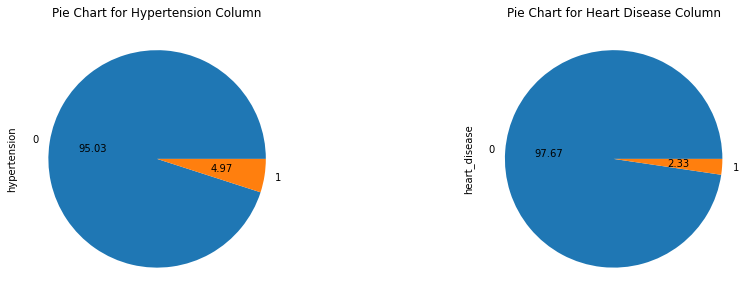

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df_train.hypertension.value_counts().plot(kind='pie',autopct="%.2f")
plt.title("Pie Chart for Hypertension Column")

plt.subplot(1,2,2)
df_train.heart_disease.value_counts().plot(kind='pie',autopct="%.2f")
plt.title("Pie Chart for Heart Disease Column")

plt.show()

In [9]:
X_cols = list(df_train.select_dtypes(include='object').columns)
X_cols.append('hypertension')
X_cols.append('heart_disease')
y_cols = list(df_train.select_dtypes(exclude='object').columns)
y_cols.remove('id')

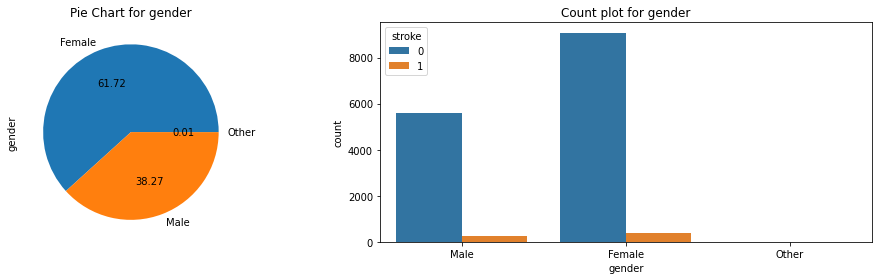

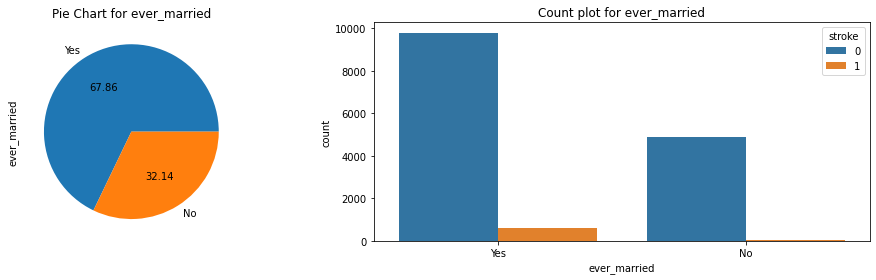

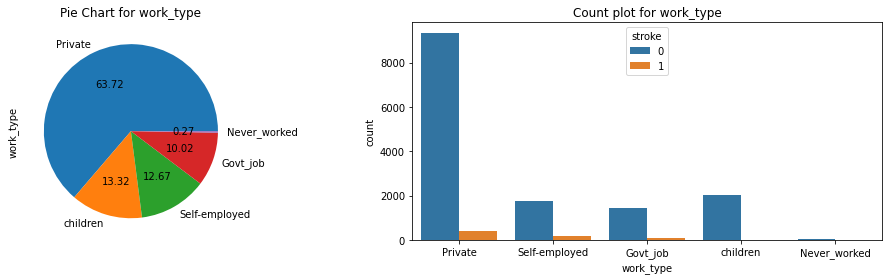

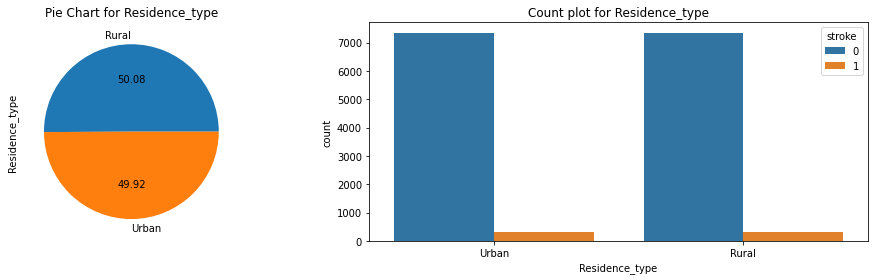

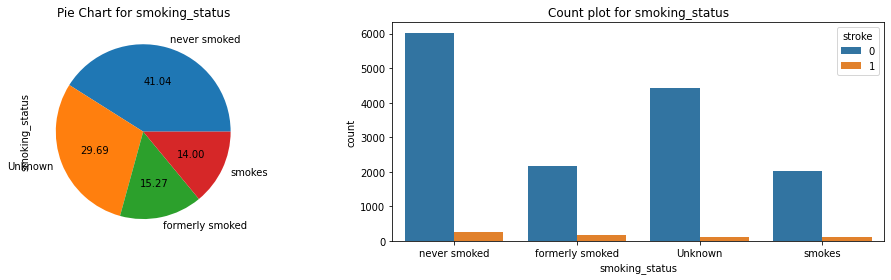

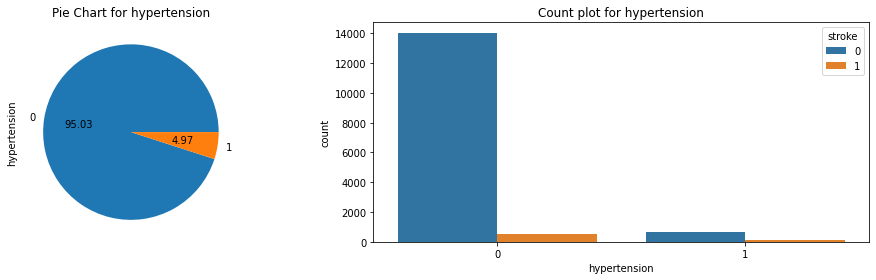

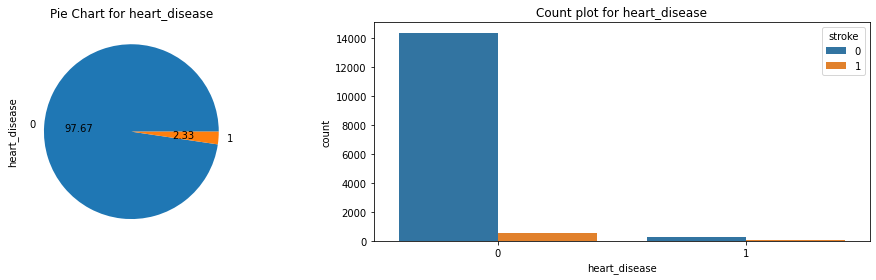

In [10]:
for col_name in X_cols:
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    df_train[col_name].value_counts().plot(kind='pie', autopct='%.2f')
    plt.title(f'Pie Chart for {col_name}')
    
    plt.subplot(1,2,2)
    sns.countplot(x=col_name,data=df_train,hue='stroke')
    plt.title(f'Count plot for {col_name}')
    plt.tight_layout()
    plt.show()

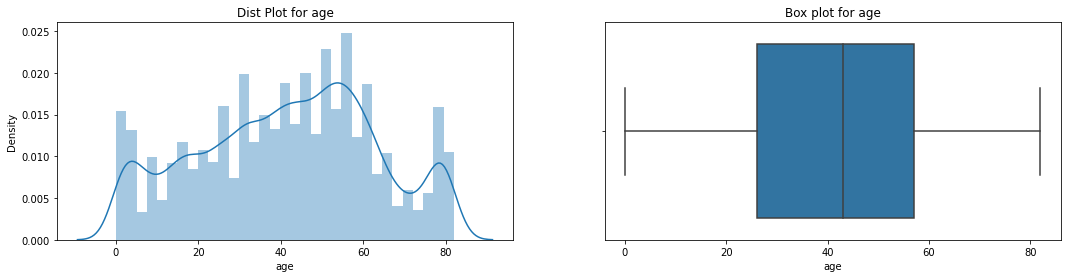

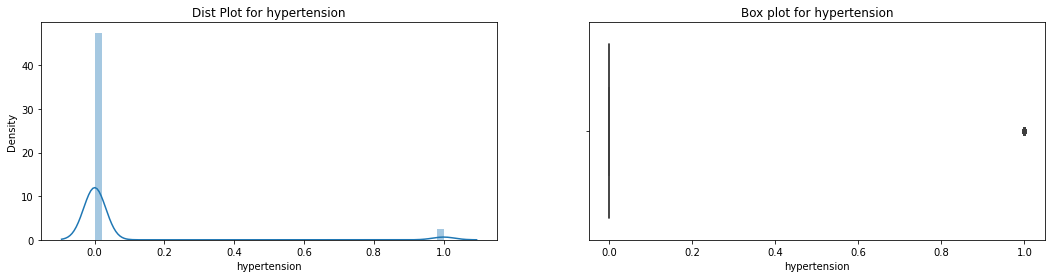

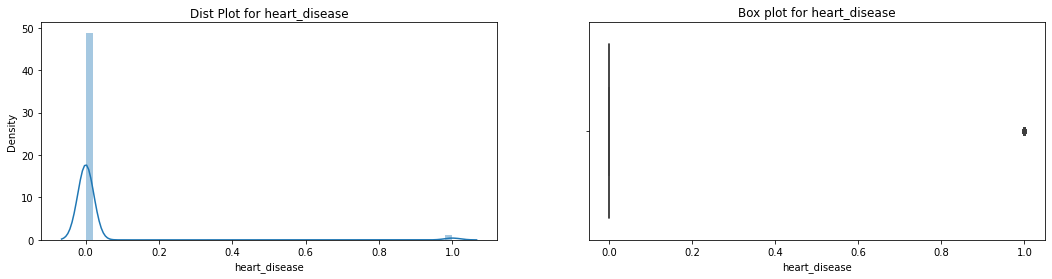

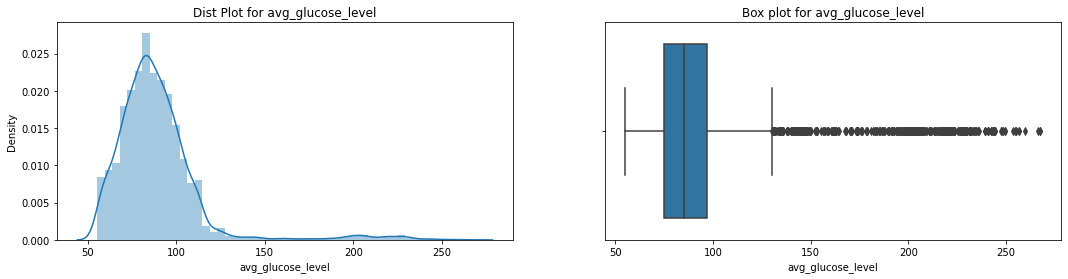

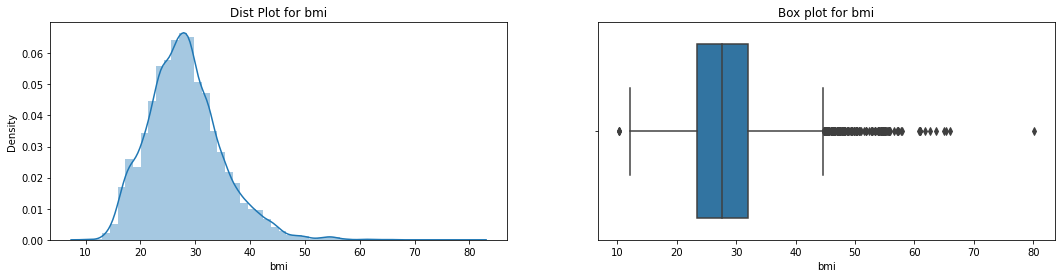

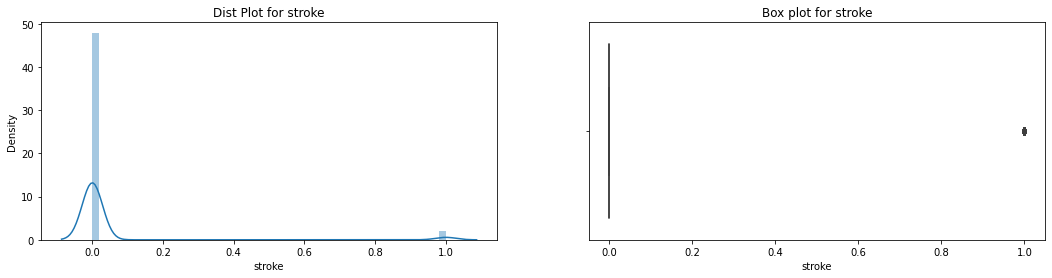

In [11]:
for col_name in y_cols:
    plt.figure(figsize=(18,4))
    plt.subplot(1,2,1)
    sns.distplot(df_train[col_name])
    plt.title(f'Dist Plot for {col_name}')
    plt.subplot(1,2,2)
    sns.boxplot(df_train[col_name],whis=1.5,orient='h')
    plt.title(f'Box plot for {col_name}')
    plt.show()

In [12]:
# from above plots, we can say there are outliers in column bmi and avg_glucose_level. We will cap those outliers
outlier_col=['bmi','avg_glucose_level']

def func_cap_val(x, col_name, ll, ul):
    if x < ll:
        return ll
    elif x > ul:
        return ul
    else:
        return x
    return 0

for col_name in outlier_col:
    q1 = np.percentile(df_train[col_name],25)
    q3 = np.percentile(df_train[col_name],75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5*iqr
    upper_limit = q3 + 1.5*iqr
    
    df_train[col_name] = df_train[col_name].apply(lambda x : func_cap_val(x,col_name, lower_limit, upper_limit))

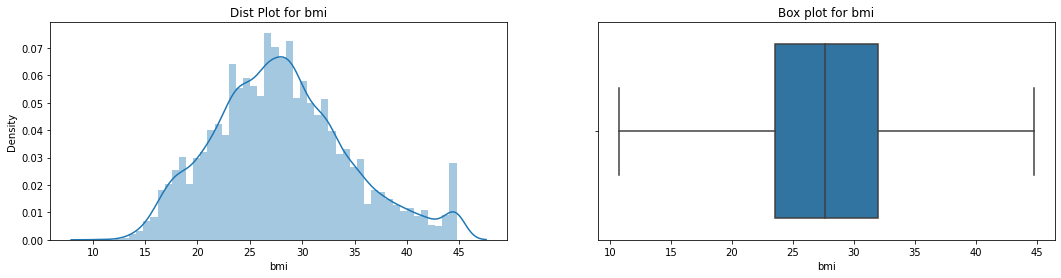

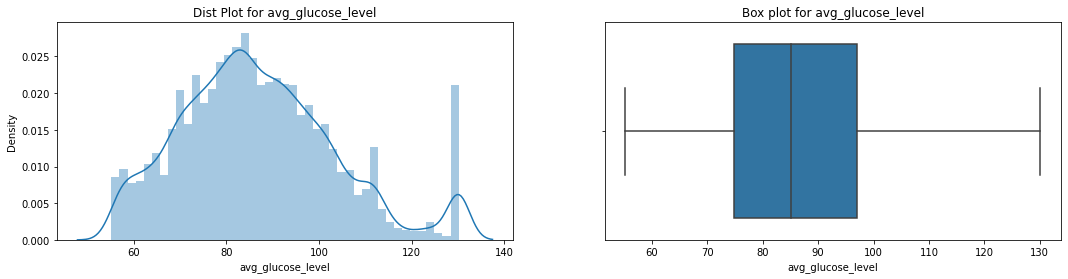

In [13]:
# to verfiy, we'll replot
for col_name in outlier_col:
    plt.figure(figsize=(18,4))
    plt.subplot(1,2,1)
    sns.distplot(df_train[col_name])
    plt.title(f'Dist Plot for {col_name}')
    plt.subplot(1,2,2)
    sns.boxplot(df_train[col_name],whis=1.5,orient='h')
    plt.title(f'Box plot for {col_name}')
    plt.show()

In [14]:
# Combining gender type 'others' with 'male'
df_train['gender_flag'] = df_train['gender'].apply(lambda x : 1 if x == 'Female' else 0)
df_train.drop(columns='gender', inplace=True)
df_train['married_flag'] = df_train['ever_married'].apply(lambda x : 1 if x == 'Yes' else 0)
df_train.drop(columns='ever_married', inplace=True)
df_train['residence_type_flag'] = df_train['Residence_type'].apply(lambda x : 1 if x == 'Urban' else 0)
df_train.drop(columns='Residence_type', inplace=True)

In [15]:
df_train.head()

,id,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke,gender_flag,married_flag,residence_type_flag
0,0,28.0,0,0,Private,79.53,31.1,never smoked,0,0,1,1
1,1,33.0,0,0,Private,78.44,23.9,formerly smoked,0,0,1,0
2,2,42.0,0,0,Private,103.00,40.3,Unknown,0,1,1,0
3,3,56.0,0,0,Private,64.87,28.8,never smoked,0,0,1,1
4,4,24.0,0,0,Private,73.36,28.8,never smoked,0,1,0,0


In [16]:
# Using dummy enconding to encode 'work_type' and 'smoking_status' columns, and then dropping the orginal columns from the dataset
cat_cols = ['work_type','smoking_status']
temp = pd.get_dummies(df_train[cat_cols], drop_first=True)
temp.head()

,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,1,0,0,0,1,0
1,0,1,0,0,1,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,1,0
4,0,1,0,0,0,1,0


In [17]:
df_train = pd.concat([df_train,temp], axis=1)
df_train.drop(columns=cat_cols, inplace=True)
df_train.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_flag,married_flag,residence_type_flag,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,28.0,0,0,79.53,31.1,0,0,1,1,0,1,0,0,0,1,0
1,1,33.0,0,0,78.44,23.9,0,0,1,0,0,1,0,0,1,0,0
2,2,42.0,0,0,103.00,40.3,0,1,1,0,0,1,0,0,0,0,0
3,3,56.0,0,0,64.87,28.8,0,0,1,1,0,1,0,0,0,1,0
4,4,24.0,0,0,73.36,28.8,0,1,0,0,0,1,0,0,0,1,0


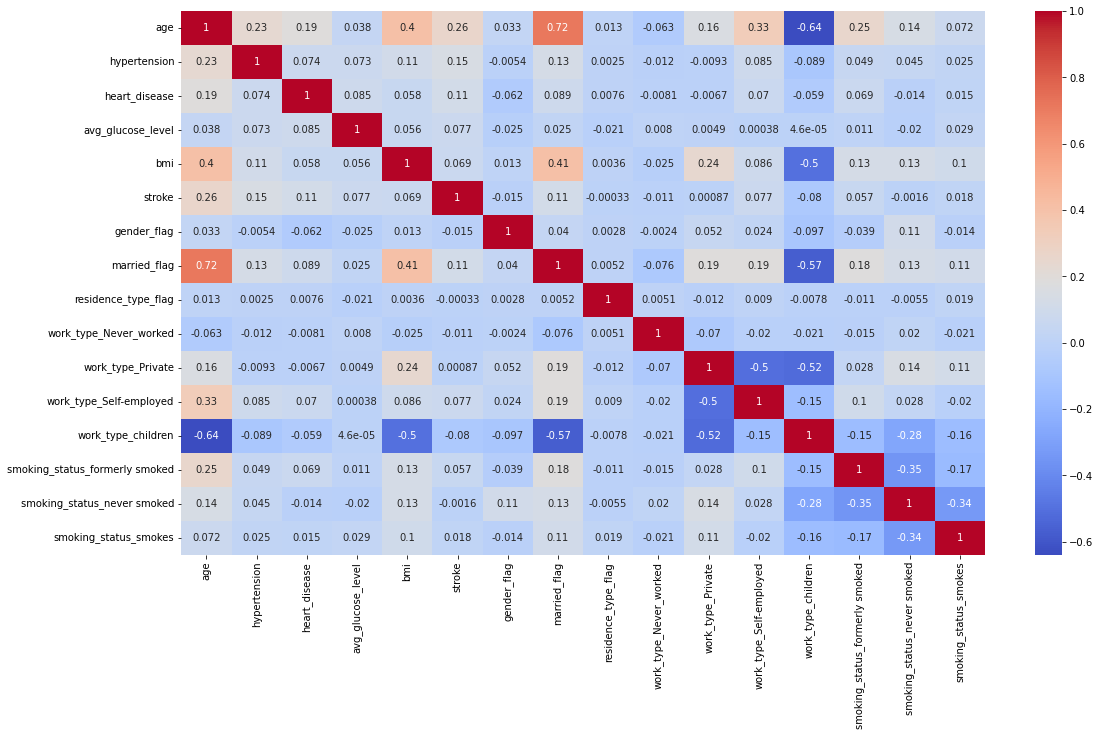

In [18]:
# Plotting heatmap to check the collinearity of independent columns with dependent columns and to check for multi-collinearty
plt.figure(figsize=(18,10))
sns.heatmap(df_train.drop(columns='id').corr(), annot=True, cmap='coolwarm')
plt.show()

Based on above heatmap, following are the observations:
1. Among all the independent variables in the dataset, 'Age' seems to be somewhat correlated to dependent variable 'Stroke'
2. Multi-collinearity is not present i.e. dependent variables are not correlated to each other.

Since the target variable is highly imbalanced, SMOTE technique is used to upsample the minority class

In [19]:
X = df_train.drop(columns=['id','stroke'])
y= df_train['stroke'].copy()
X_cols = list(X.columns)
smote = SMOTE(random_state=42)
X,y = smote.fit_resample(X,y)
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.75,random_state=42)
cols_to_norm = ['age','bmi','avg_glucose_level']
scaler_x = StandardScaler(with_mean=False)
X_train[cols_to_norm] = pd.DataFrame(scaler_x.fit_transform(X_train[cols_to_norm]),columns=cols_to_norm)
X_val[cols_to_norm] = pd.DataFrame(scaler_x.transform(X_val[cols_to_norm]),columns=cols_to_norm)

In [20]:
X = df_train.drop(columns=['id','stroke'])
y= df_train['stroke'].copy()
X_cols = list(X.columns)

smote = SMOTE(random_state=42)
X,y = smote.fit_resample(X,y)

In [21]:
X_train,X_val,y_train,y_val = train_test_split(X,y,train_size=0.75,random_state=42)

cols_to_norm = ['age','bmi','avg_glucose_level']
scaler_x = StandardScaler(with_mean=False)

X_train[cols_to_norm] = pd.DataFrame(scaler_x.fit_transform(X_train[cols_to_norm]),columns=cols_to_norm)
X_val[cols_to_norm] = pd.DataFrame(scaler_x.transform(X_val[cols_to_norm]),columns=cols_to_norm)

In [22]:
print(scaler_x)

StandardScaler(with_mean=False)


In [23]:
print(X_train.shape)
print(X_val.shape)

(22008, 15)
(7336, 15)


In [24]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(missing_values=np.NaN,n_neighbors=3)
X_train = pd.DataFrame(imputer.fit_transform(X_train),columns=X_cols)
X_val = pd.DataFrame(imputer.transform(X_val),columns=X_cols)

### 4. Linear Regression Model

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
# vectorizer = CountVectorizer()  # You can use a suitable text vectorizer
# X_train_encoded = vectorizer.fit_transform(X_train)

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [26]:
def get_results(model,in_df,true_df):
    y_probs_pred = model.predict_proba(in_df)[:,1]
    y_pred = model.predict(in_df)

    auc_score = roc_auc_score(true_df,y_probs_pred)
    f1_score_1 = f1_score(true_df,y_pred)
    prcs_score = precision_score(true_df,y_pred)
    recall_score_1 = recall_score(true_df,y_pred)

    print(f'ROC AUC score on input dataset is {auc_score}')
    print('Classification report is shown below: ')
    print(classification_report(true_df,y_pred))

In [27]:
get_results(lr, X_train, y_train)

ROC AUC score on input dataset is 0.8820308745712944
Classification report is shown below: 
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     10966
           1       0.80      0.78      0.79     11042

    accuracy                           0.79     22008
   macro avg       0.79      0.79      0.79     22008
weighted avg       0.79      0.79      0.79     22008



In [28]:
get_results(lr, X_val, y_val)

ROC AUC score on input dataset is 0.8808792680769328
Classification report is shown below: 
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      3706
           1       0.79      0.78      0.79      3630

    accuracy                           0.79      7336
   macro avg       0.79      0.79      0.79      7336
weighted avg       0.79      0.79      0.79      7336



#### 4.1 Logistic Regression Hyperparameter tuning

In [29]:
lr_cv = LogisticRegression()

param = {
    'C':[0.1,0.25,0.5,0.75,1,10,15,20,50,100],
    'penalty':['l1','l2']
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = GridSearchCV(estimator=lr_cv,
                     param_grid=param,
                     scoring='roc_auc',
                     cv=folds,
                     return_train_score=True,
                     verbose=1)

model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.25, 0.5, 0.75, 1, 10, 15, 20, 50, 100],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [30]:
score_round_1 = model.best_score_
print(f'Best score obtained after hyperparameter tuning round 1 is {model.best_score_}')
print(f'Best estimatore obtained is {model.best_estimator_}')
print(f'Best parameters obtained for model are {model.best_params_}')

Best score obtained after hyperparameter tuning round 1 is 0.8805597335389521
Best estimatore obtained is LogisticRegression(C=0.1)
Best parameters obtained for model are {'C': 0.1, 'penalty': 'l2'}


#### 4.2 Hyperparameter tuning round 2

In [31]:
"""params_round_1 = model.best_params_
c_val = params_round_1.get('C')

param= {'C': [x for x in range(int(c_val-20),int(c_val+20))],
        'penalty': ['l1', 'l2']}

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

model= GridSearchCV(estimator= lr_cv,
                    param_grid=param,
                    scoring="roc_auc",
                    cv=folds,
                    return_train_score=True,
                    verbose=1)

model.fit(X_train,y_train)"""

'params_round_1 = model.best_params_\nc_val = params_round_1.get(\'C\')\n\nparam= {\'C\': [x for x in range(int(c_val-20),int(c_val+20))],\n        \'penalty\': [\'l1\', \'l2\']}\n\nfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)\n\nmodel= GridSearchCV(estimator= lr_cv,\n                    param_grid=param,\n                    scoring="roc_auc",\n                    cv=folds,\n                    return_train_score=True,\n                    verbose=1)\n\nmodel.fit(X_train,y_train)'

In [32]:
for col_name in outlier_col:
    q1 = np.percentile(df_test[col_name],25)
    q3 = np.percentile(df_test[col_name],75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5*iqr
    upper_limit = q1 + 1.5*iqr
    df_test[col_name] = df_test[col_name].apply(lambda x: func_cap_val(x,col_name,lower_limit,upper_limit))

In [33]:
df_test['gender_flag'] = df_test['gender'].apply(lambda x: 1 if x == 'Female' else 0)
df_test.drop(columns='gender',inplace=True)

df_test['married_flag'] = df_test['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)
df_test.drop(columns='ever_married',inplace=True)

df_test['residence_type_flag'] = df_test['Residence_type'].apply(lambda x: 1 if x == 'Urban' else 0)
df_test.drop(columns='Residence_type',inplace=True)

In [34]:
temp = pd.get_dummies(df_test[cat_cols],drop_first=True)
df_test = pd.concat([df_test,temp], axis=1)
df_test.drop(columns=cat_cols,inplace=True)

In [35]:
X_test = df_test[X_cols]
X_test[cols_to_norm] = pd.DataFrame(scaler_x.transform(X_test[cols_to_norm]),columns=cols_to_norm)
X_test = pd.DataFrame(imputer.transform(X_test),columns=X_cols)

In [36]:
"""y_test_pred = model.predict_proba(X_test)[:,1]
y_test_pred = pd.DataFrame(y_test_pred,columns=['stroke_lr'])

df_test = pd.concat([df_test,y_test_pred],axis=1)"""

"y_test_pred = model.predict_proba(X_test)[:,1]\ny_test_pred = pd.DataFrame(y_test_pred,columns=['stroke_lr'])\n\ndf_test = pd.concat([df_test,y_test_pred],axis=1)"

### 5. XGBoost Classifier (Default parameters)

In [37]:
X_train[cols_to_norm] = X_train[cols_to_norm].astype('float')
X_val[cols_to_norm] = X_val[cols_to_norm].astype('float')

In [49]:
xgb = XGBClassifier(objective='binary:logistic',seed=42) #,tree_method='gpu_hist')

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [50]:
get_results(xgb, X_train, y_train)

ROC AUC score on input dataset is 0.9690128315797065
Classification report is shown below: 
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     10966
           1       0.92      0.89      0.90     11042

    accuracy                           0.90     22008
   macro avg       0.90      0.90      0.90     22008
weighted avg       0.90      0.90      0.90     22008



In [51]:
get_results(xgb, X_val, y_val)

ROC AUC score on input dataset is 0.9066464700976303
Classification report is shown below: 
              precision    recall  f1-score   support

           0       0.96      0.53      0.68      3706
           1       0.67      0.97      0.79      3630

    accuracy                           0.75      7336
   macro avg       0.81      0.75      0.74      7336
weighted avg       0.81      0.75      0.74      7336



#### 5.1 Predictions on test dataset

In [52]:
y_test_pred = xgb.predict_proba(X_test)[:,1]
y_test_pred = pd.DataFrame(y_test_pred, columns=['stroke_xgb'])

df_test = pd.concat([df_test,y_test_pred],axis=1)

#### 5.2 XGBoost Model (Hyperparameter tuning)

In [53]:
def objective(trial,X,y):
    param = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }
    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = pd.DataFrame(y).iloc[train_idx], pd.DataFrame(y).iloc[test_idx]
        model = XGBClassifier(objective="binary:logistic", **param)
        model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="auc",
        early_stopping_rounds=100,
        verbose=0,
        callbacks=[optuna.integration.XGBoostPruningCallback(trial, "validation_0-auc")],
        )
        preds = model.predict_proba(X_test)[:,1]
        cv_scores[idx] = roc_auc_score(y_test, preds)
        # Add a pruning callback
    return np.mean(cv_scores)

In [54]:
study = optuna.create_study(direction='maximize', study_name="XGBoost classifier")
func = lambda trial : objective(trial, X_train, y_train)
study.optimize(func, n_trials=100)

In [55]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.92728
	Best params:
		booster: dart
		lambda: 3.340145483867105e-08
		alpha: 0.00024016252267407544
		max_depth: 8
		eta: 0.185011353719256
		gamma: 0.005522859673169749
		grow_policy: lossguide
		sample_type: weighted
		normalize_type: forest
		rate_drop: 0.0554699192089454
		skip_drop: 0.01987221251688014


In [56]:
optuna.visualization.plot_optimization_history(study)

In [57]:
xgb_final = XGBClassifier(objective="binary:logistic",**study.best_params)

xgb_final.fit(X_train, y_train)

XGBClassifier(alpha=0.00024016252267407544, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.185011353719256, eval_metric=None,
              feature_types=None, gamma=0.005522859673169749, gpu_id=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, lambda=3.340145483867105e-08,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)

In [58]:
get_results(xgb_final,X_train,y_train)

ROC AUC score on input dataset is 0.9779041188811589
Classification report is shown below: 
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     10966
           1       0.93      0.91      0.92     11042

    accuracy                           0.92     22008
   macro avg       0.92      0.92      0.92     22008
weighted avg       0.92      0.92      0.92     22008



In [59]:
get_results(xgb_final,X_val,y_val)

ROC AUC score on input dataset is 0.9069641739476897
Classification report is shown below: 
              precision    recall  f1-score   support

           0       0.96      0.52      0.68      3706
           1       0.67      0.98      0.79      3630

    accuracy                           0.75      7336
   macro avg       0.81      0.75      0.74      7336
weighted avg       0.81      0.75      0.73      7336



#### 5.4 predictions on test set

In [60]:
y_test_pred = xgb_final.predict_proba(X_test)[:,1]
y_test_pred = pd.DataFrame(y_test_pred,columns=['stroke_xgb_cv'])
df_test = pd.concat([df_test,y_test_pred],axis=1)

### 6. Catboost Model

In [61]:
train_cb = pd.read_csv(train_src_path)
test_cb = pd.read_csv(test_src_path)

In [62]:
train_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [63]:
cat_cols_cb = list(train_cb.select_dtypes(include='object').columns)
cat_cols_cb.append('hypertension')
cat_cols_cb.append('heart_disease')

X_cb = train_cb.drop(columns=['id','stroke'])
y_cb = train_cb['stroke']

X_train_cb,X_val_cb,y_train_cb,y_val_cb = train_test_split(X_cb,y_cb,train_size=0.75,random_state=42,stratify=y_cb)

In [65]:
!pip3 install catboost

     |████████████████████████████████| 98.7 MB 117 kB/s eta 0:00:01     |██████████████                  | 43.0 MB 460 kB/s eta 0:02:02


In [66]:
from catboost import CatBoostClassifier

In [67]:
cb = CatBoostClassifier(random_state=42,class_weights={0:0.1,1:0.9},eval_metric='AUC',verbose=0)
cb.fit(X_train_cb,y_train_cb,cat_features=cat_cols_cb,)

In [69]:
get_results(cb, X_train_cb, y_train_cb)

ROC AUC score on input dataset is 0.9885837447679172
Classification report is shown below: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     11004
           1       0.54      0.91      0.67       474

    accuracy                           0.96     11478
   macro avg       0.77      0.94      0.83     11478
weighted avg       0.98      0.96      0.97     11478



In [70]:
get_results(cb, X_val_cb, y_val_cb)

ROC AUC score on input dataset is 0.8783025965241638
Classification report is shown below: 
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3668
           1       0.29      0.46      0.35       158

    accuracy                           0.93      3826
   macro avg       0.63      0.71      0.66      3826
weighted avg       0.95      0.93      0.94      3826



#### 6.1 prediction on test dataset

In [71]:
X_test_cb = test_cb.drop(columns=['id'])

y_test_pred = cb.predict_proba(X_test_cb)[:,1]
y_test_pred = pd.DataFrame(y_test_pred,columns=['stroke_cb'])

df_test = pd.concat([df_test,y_test_pred],axis=1)

#### 6.2 Hyperparameter tuning for CatBoost model

In [78]:
def objective(trial, X, y,cat_col_list=cat_cols_cb):
    param_grid = {
    "objective": trial.suggest_categorical("objective", ["Logloss"]),
    # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
    "depth": trial.suggest_int("depth", 3, 15),
    "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
    # "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS","Poisson"]),
    "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    "iterations" : trial.suggest_int("iterations",5000,35000,step=200),
    'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
    # 'max_bin': trial.suggest_int('max_bin', 200, 400),
    'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.9),
    # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    "scale_pos_weight" : trial.suggest_int("scale_pos_weight",2,50)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = pd.DataFrame(y).iloc[train_idx], pd.DataFrame(y).iloc[test_idx]
        #
        model = CatBoostClassifier(**param_grid,eval_metric='AUC')
        model.fit(
        X_train,
        y_train,
        cat_features=cat_col_list,
        eval_set=[(X_test, y_test)],
        # eval_metric="auc",
        early_stopping_rounds=100,
        callbacks=[optuna.integration.CatBoostPruningCallback(trial, "AUC")],
        verbose=0
        )

    preds = model.predict_proba(X_test)[:,1]
    cv_scores[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_scores)

In [81]:
study = optuna.create_study(direction='maximize', study_name="CatBoost Classifier")
func = lambda trial: objective(trial, X_train_cb, y_train_cb)
study.optimize(func, n_trials=100)

In [82]:
print(f"\tBest value (auc): {study.best_value:.5f}")
print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (auc): 15.06045
	Best params:
		objective: Logloss
		depth: 12
		boosting_type: Ordered
		bootstrap_type: Bernoulli
		iterations: 10800
		l2_leaf_reg: 0.15037500308237706
		learning_rate: 0.26587079946308234
		scale_pos_weight: 2


In [84]:
optuna.visualization.plot_optimization_history(study)

In [86]:
cb_final = CatBoostClassifier(**study.best_params,eval_metric='AUC',verbose=0)
cb_final.fit(X_train_cb,y_train_cb,cat_features=cat_cols_cb)

In [87]:
get_results(cb_final,X_train_cb,y_train_cb)

ROC AUC score on input dataset is 0.9989493655548346
Classification report is shown below: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11004
           1       0.97      0.91      0.93       474

    accuracy                           0.99     11478
   macro avg       0.98      0.95      0.97     11478
weighted avg       0.99      0.99      0.99     11478



In [88]:
get_results(cb_final,X_val_cb,y_val_cb)

ROC AUC score on input dataset is 0.8415185042033047
Classification report is shown below: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3668
           1       0.23      0.09      0.14       158

    accuracy                           0.95      3826
   macro avg       0.60      0.54      0.55      3826
weighted avg       0.93      0.95      0.94      3826



#### 6.3 Predictions on Test Dataset

In [89]:
y_test_pred = cb_final.predict_proba(X_test_cb)[:,1]
y_test_pred = pd.DataFrame(y_test_pred,columns=['stroke_cb_cv'])
df_test = pd.concat([df_test,y_test_pred],axis=1)

### 7. LightGBM Model
without encoding the categorical data and without scaling the data

In [90]:
X_cb[cat_cols_cb] = X_cb[cat_cols_cb].astype('category')

In [91]:
X_train_lgb,X_val_lgb,y_train_lgb,y_val_lgb = train_test_split(X_cb, y_cb, train_size=0.75, stratify=y_cb)

In [92]:
lgb_cat = lgbm.LGBMClassifier(random_state=42, class_weight={0:0.1,1:0.9})
lgb_cat.fit(X_train_lgb,y_train_lgb)

LGBMClassifier(class_weight={0: 0.1, 1: 0.9}, random_state=42)

In [93]:
get_results(lgb_cat, X_train_lgb, y_train_lgb)

ROC AUC score on input dataset is 0.9908674367740461
Classification report is shown below: 
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     11004
           1       0.49      0.96      0.65       474

    accuracy                           0.96     11478
   macro avg       0.74      0.96      0.81     11478
weighted avg       0.98      0.96      0.96     11478



In [94]:
get_results(lgb_cat, X_val_lgb, y_val_lgb)

ROC AUC score on input dataset is 0.8656633491158566
Classification report is shown below: 
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      3668
           1       0.23      0.45      0.31       158

    accuracy                           0.92      3826
   macro avg       0.60      0.69      0.63      3826
weighted avg       0.94      0.92      0.93      3826



#### 7.1 LightBGM Model Hyperparmaeter tuning

In [95]:
def objective(trial, X, y):
    param_grid = {
        "boosting_type" : trial.suggest_categorical("boosting_type",['gbdt','dart']),
        "n_estimators": trial.suggest_int("n_estimators", 100,2500,step=50),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 25, 5000, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=50),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 1.0, step=0.1),
        # "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 1.0, step=0.05),
        # "scale_pos_weight" : trial.suggest_float("scale_pos_weight",2,40,step=0.1)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = pd.DataFrame(y).iloc[train_idx], pd.DataFrame(y).iloc[test_idx]
        #
        model = lgbm.LGBMClassifier(objective="binary",verbose=-1, **param_grid)
        model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="auc",
        early_stopping_rounds=100,
        callbacks=[LightGBMPruningCallback(trial, "auc")], # Add a pruning callback
        verbose=-1
        )
        preds = model.predict_proba(X_test)[:,1]
        cv_scores[idx] = roc_auc_score(y_test, preds)
    return np.mean(cv_scores)

In [96]:
study = optuna.create_study(direction='maximize', study_name='LGBM Classifier using Non Scaled Data')
func = lambda trial: objective(trial, X_train_lgb, y_train_lgb)
study.optimize(func, n_trials=100)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=3.922814437879744e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.922814437879744e-07
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=8.48729908831221e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.48729908831221e-05
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=3.922814437879744e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.922814437879744e-07
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current va

In [97]:
print(f"\tBest Value (auc):{study.best_value:.5f}")
print(f"\tBest params :")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best Value (auc):0.88939
	Best params :
		boosting_type: gbdt
		n_estimators: 550
		learning_rate: 0.11932987330093593
		num_leaves: 4685
		max_depth: 8
		min_data_in_leaf: 800
		lambda_l1: 5.463434740210374e-08
		lambda_l2: 0.03167844872736576
		bagging_fraction: 0.7
		feature_fraction: 0.5


In [99]:
optuna.visualization.plot_optimization_history(study)

In [100]:
optuna.visualization.plot_param_importances(study)

In [101]:
lgb_cat_final = lgbm.LGBMClassifier(objective="binary", **study.best_params)
lgb_cat_final.fit(X_train_lgb, y_train_lgb)

LGBMClassifier(bagging_fraction=0.7, feature_fraction=0.5,
               lambda_l1=5.463434740210374e-08, lambda_l2=0.03167844872736576,
               learning_rate=0.11932987330093593, max_depth=8,
               min_data_in_leaf=800, n_estimators=550, num_leaves=4685,
               objective='binary')

In [102]:
get_results(lgb_cat_final, X_train_lgb, y_train_lgb)

ROC AUC score on input dataset is 0.9703464179500512
Classification report is shown below: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     11004
           1       0.91      0.25      0.39       474

    accuracy                           0.97     11478
   macro avg       0.94      0.62      0.69     11478
weighted avg       0.97      0.97      0.96     11478



In [103]:
get_results(lgb_cat_final, X_val_lgb, y_val_lgb)

ROC AUC score on input dataset is 0.8581574479245752
Classification report is shown below: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3668
           1       0.33      0.09      0.15       158

    accuracy                           0.95      3826
   macro avg       0.65      0.54      0.56      3826
weighted avg       0.94      0.95      0.94      3826



#### 7.2 Predictions on Test Dataset

In [105]:
df_test.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'gender_flag', 'married_flag', 'residence_type_flag',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'stroke_xgb', 'stroke_xgb', 'stroke_xgb',
       'stroke_xgb_cv', 'stroke_cb', 'stroke_cb_cv'],
      dtype='object')

In [106]:
X_lgb_cols = list(X_val.columns)
X_test_lgb = df_test[X_lgb_cols]

y_test_pred = lgb_cat_final.predict(X_test_lgb)[:,1]
y_test_pred = pd.DataFrame(y_test_pred, columns=['stroke_lgb_cat_cv'])

df_test = pd.concat([df_test, y_test_pred], axis=1)

ValueError: Number of features of the model must match the input. Model n_features_ is 10 and input n_features is 15